# Data Exploration (transactions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mpld3 as mpld3
from ggplot import *
import seaborn as sns
import time
from datetime import datetime
from collections import Counter
from pandas.lib import Timestamp
from pandas.core import datetools

/Users/pablodepaz/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/pablodepaz/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/pablodepaz/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. transactions
## 1.1. Loading the data

In [2]:
url_trans = "data/transactions_v2.csv"
trans_data = pd.read_csv(url_trans)

In [3]:
#Summary of the data
print(trans_data.shape)
print(trans_data.info())
print(trans_data.describe())

(1431009, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431009 entries, 0 to 1431008
Data columns (total 9 columns):
msno                      1431009 non-null object
payment_method_id         1431009 non-null int64
payment_plan_days         1431009 non-null int64
plan_list_price           1431009 non-null int64
actual_amount_paid        1431009 non-null int64
is_auto_renew             1431009 non-null int64
transaction_date          1431009 non-null int64
membership_expire_date    1431009 non-null int64
is_cancel                 1431009 non-null int64
dtypes: int64(8), object(1)
memory usage: 98.3+ MB
None
       payment_method_id  payment_plan_days  plan_list_price  \
count       1.431009e+06       1.431009e+06     1.431009e+06   
mean        3.791835e+01       6.601770e+01     2.817870e+02   
std         4.964805e+00       1.024864e+02     4.351861e+02   
min         2.000000e+00       0.000000e+00     0.000000e+00   
25%         3.600000e+01       3.000000e+01     9.900000e

We have 8 features (in addition to the ID, "msno"). I can draw the following conclusions:
- All features are of type Integer with 64 bits except the ID (msno), that is an object.
- payment_method_id is encoded in integer from [1,41]. The most common value is 41.
- payment_plan_days measures the length of membership subscription in days. Typically, a user would subscribe 30 days (and then re-subscribe, automanically or manually). Values are [0, 450], being 30 the most popular.
- plan_list_price and actual_amount_paid shows the theoretical and actual subscription price in units of New Taiwan Dollar (NTD). Values range [0, 2000]. Mean is a bit higher in _list_ than in _actual_ paid. Maybe this is because some promotions or problems with payment.
- is_auto_renew is binary: 0 or 1. It shows if transaction was automatically renewed. Mean is 0.85 so most of the user chose this option.
- transaction_date and membership_expire_date are the KEY FEATURES to determine if an user has churned. Definition can be seen below.
- is_cancel shows if an user cancels a transaction. Could lead to churn.

### Churn: "no new valid service subscription within 30 days after the current membership expires"

In [4]:
trans_data.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


## 1.2. Univariate descriptions
Features (columns) analysis

**In this part, I will first analyse each feature and then get rid of the outliyes or extreme values in the graphs**

### 1.2.1. Feature: _Payment Method ID_

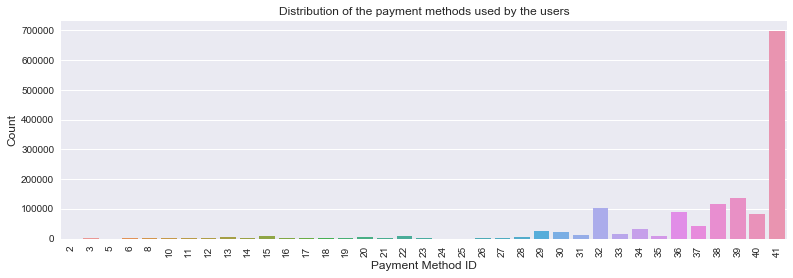

In [5]:
# Features visualization
mpld3.enable_notebook()

sns.set(rc={'figure.figsize':(13,4)}) #Horizontal, vertical
sns.countplot(x='payment_method_id', data=trans_data)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Payment Method ID', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of the payment methods used by the users", fontsize=12)
plt.show()

Payment Method 41 is the most popular one.
In addition, methods above 30 are used by a noticeable amount of users.

Next, I will only plot values above 30, as they are the ones with a relevant importance in the overall distribution.

(75979, 9)


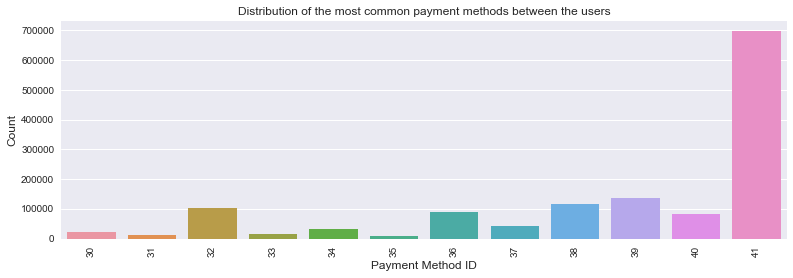

In [6]:
#Number of values below 30!
print(trans_data[trans_data.payment_method_id <= 29].shape)

payment_method_id_var = trans_data[trans_data.payment_method_id > 29]
sns.countplot(x='payment_method_id',data=payment_method_id_var)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Payment Method ID', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of the most common payment methods between the users", fontsize=12)
plt.show()

### 1.2.2. Feature: _Payment plan duration (in days)_
Length of membership subscription in days

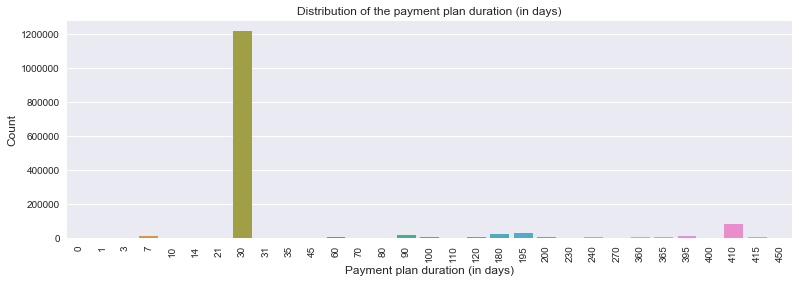

In [7]:
#trans_data.hist(column='payment_plan_days', bins=100, facecolor='r') #plt.ylabel('Nº of samples') #plt.xlabel('Nº of days') #plt.title('Payment Plan Duration')

sns.set(rc={'figure.figsize':(13,4)}) #Horizontal, vertical
sns.countplot(x='payment_plan_days',data=trans_data)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Payment plan duration (in days)', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of the payment plan duration (in days)", fontsize=12)
plt.show()

Most of the users' plan is 30 days. Even though, some values in 0, 7 and 31 days can be observed (between others).

Next, I will only plot values below 60, as they are the ones with a relevant importance in the overall distribution.

(197357, 9)


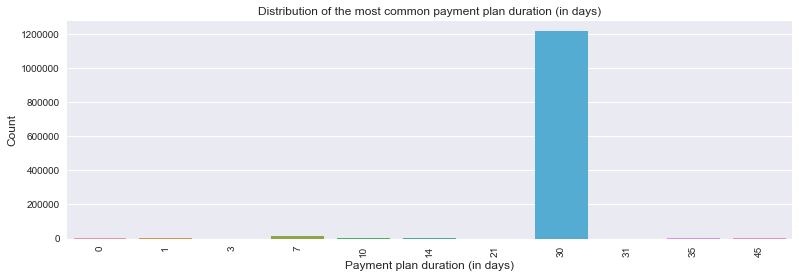

In [8]:
#Number of values above 60
print(trans_data[trans_data.payment_plan_days >= 60].shape)

payment_plan_days_var = trans_data[trans_data.payment_plan_days < 60]
sns.countplot(x='payment_plan_days',data=payment_plan_days_var)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Payment plan duration (in days)', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of the most common payment plan duration (in days)", fontsize=12)
plt.show()

### 1.2.3. Features: _Plan Price_ and _Amount Paid_
Shows the theoretical and actual subscription price in units of New Taiwan Dollar (NTD). 
Mean is a bit higher in list than in actual paid. Maybe this is because some promotions or problems with payment.

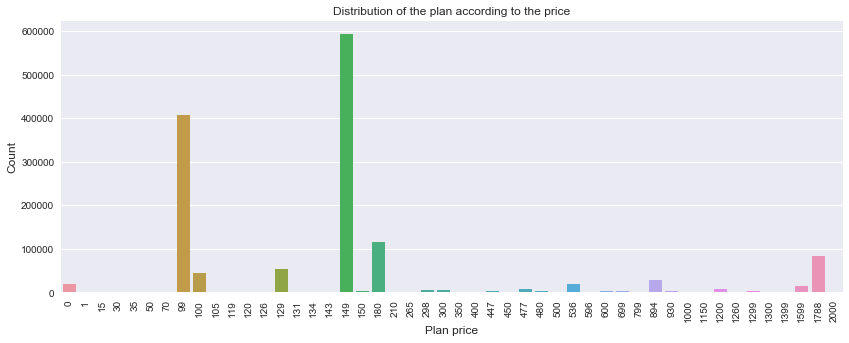

In [9]:
sns.set(rc={'figure.figsize':(14,5)}) #Horizontal, vertical
sns.countplot(x='plan_list_price',data=trans_data)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Plan price', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of the plan according to the price", fontsize=12)
plt.show()

I will do a bar plot and use only the values below 210 which are more significant for the distribution.

(194430, 9)


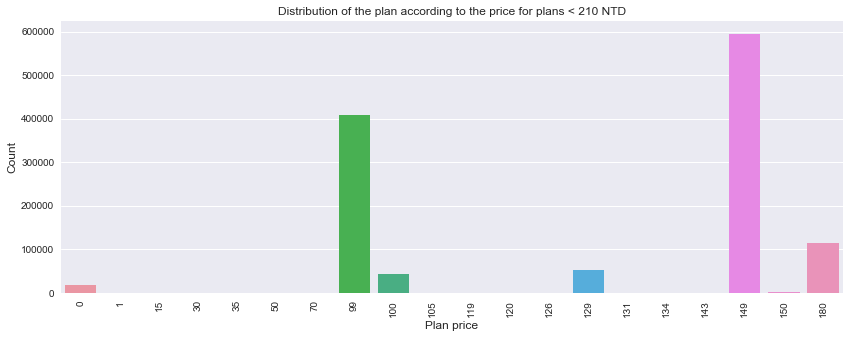

In [10]:
#Number of values above 210
print(trans_data[trans_data.plan_list_price >= 210].shape)

plan_list_price_var = trans_data[trans_data.plan_list_price < 210]
sns.countplot(x='plan_list_price',data=plan_list_price_var)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Plan price', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of the plan according to the price for plans < 210 NTD", fontsize=12)
plt.show()

On the other hand, for the "actual amount paid"

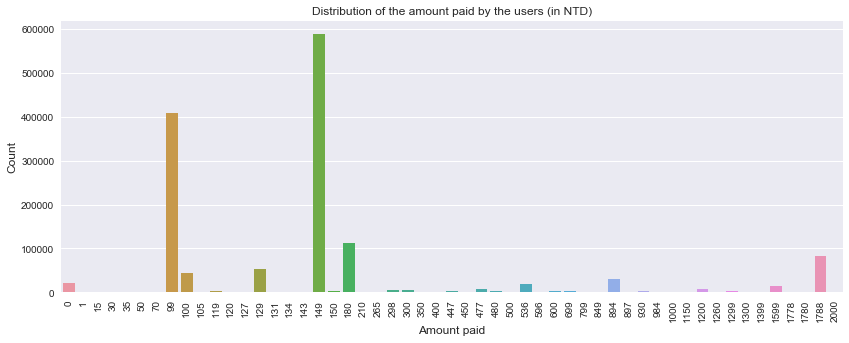

In [11]:
sns.set(rc={'figure.figsize':(14,5)}) #Horizontal, vertical
sns.countplot(x='actual_amount_paid',data=trans_data)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Amount paid', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of the amount paid by the users (in NTD)", fontsize=12)
plt.show()

I will do a bar plot and use only the values below 210 which are more significant for the distribution.

(194467, 9)


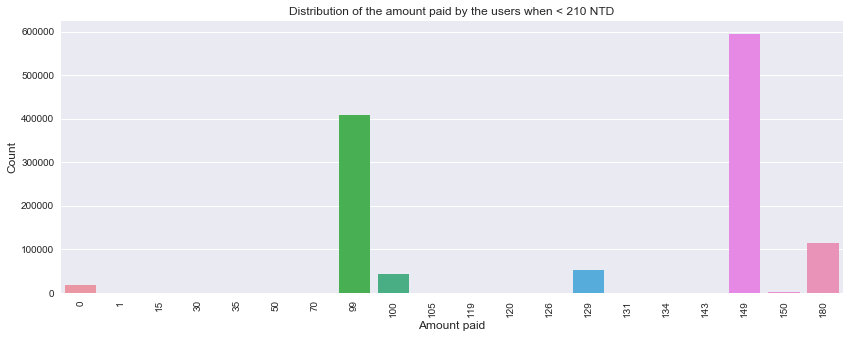

In [12]:
#Number of values above 210
print(trans_data[trans_data.actual_amount_paid >= 210].shape)

plan_list_price_var = trans_data[trans_data.plan_list_price < 210]
sns.countplot(x='plan_list_price',data=plan_list_price_var)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Amount paid', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of the amount paid by the users when < 210 NTD", fontsize=12)
plt.show()

Overall distributions are very similar. Still, some differences are visible such as for 119 NTD.
We can compare their frequency as they are discrete values.

**Now, in the next codebox, I create a new FEATURE as the difference between the "plan price" and "actual amount paid"**

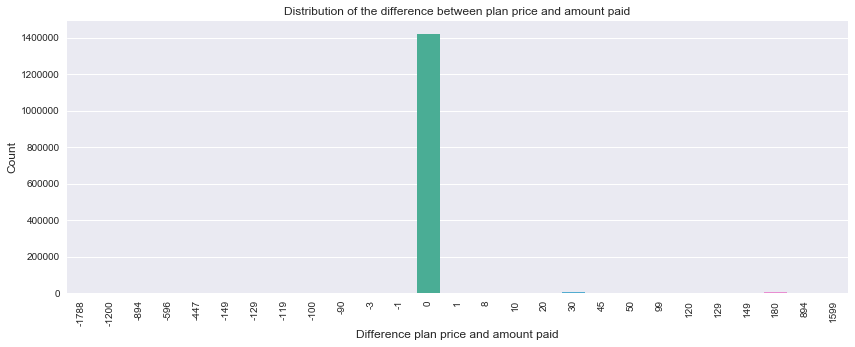

In [13]:
trans_data['diff_plan_actual'] = trans_data['plan_list_price'] - trans_data['actual_amount_paid']
sns.set(rc={'figure.figsize':(14,5)}) #Horizontal, vertical
sns.countplot(x='diff_plan_actual',data=trans_data)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Difference plan price and amount paid', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of the difference between plan price and amount paid", fontsize=12)
plt.show()

VALUE 0 is not important as it is what it should be (you pay what you get). This way, I will erase it from the plot above (in the following plot, below).

(1419106, 10)


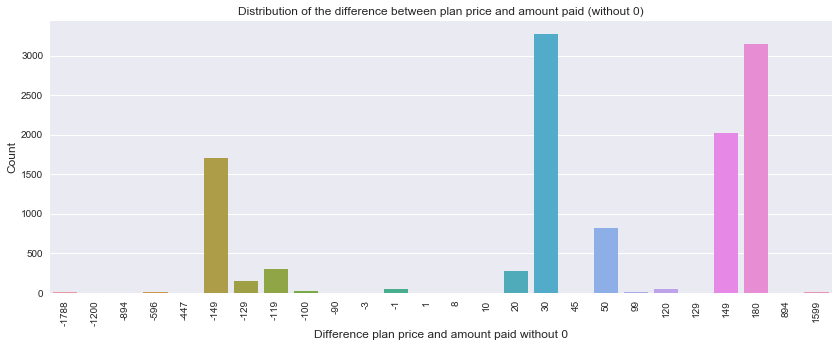

In [14]:
print(trans_data[trans_data.diff_plan_actual == 0].shape)

diff_plan_actual_var = trans_data[trans_data.diff_plan_actual != 0]
sns.set(rc={'figure.figsize':(14,5)}) #Horizontal, vertical
sns.countplot(x='diff_plan_actual', data=diff_plan_actual_var)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Difference plan price and amount paid without 0', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of the difference between plan price and amount paid (without 0)", fontsize=12)
plt.show()

It can be observed that most of the people paid (as 0 is very large) but there are some mismatches for individual users.
Interestingly, in some cases, the users end up paying more (positive values). This can be better seen in the 2nd graph where "0" values have been taken away.

In [15]:
trans_data['plan_list_price'].corr(trans_data['actual_amount_paid'],method='pearson')    

0.9994581971674552

**Around 920K values are zero, which means that correlation between these 2 features is around 99%.**

### 1.2.4. Feature: _auto renew_ subscription
It shows if transaction was automatically renewed (if 1). 
Most of the users choose this option (automatic renewal).

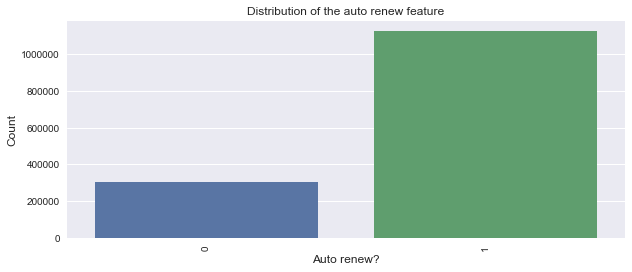

is_auto_renew Count [(1, 1123775), (0, 307234)]


In [16]:
sns.set(rc={'figure.figsize':(10,4)}) #Horizontal, vertical
sns.countplot(x='is_auto_renew',data=trans_data)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Auto renew?', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of the auto renew feature", fontsize=12)
plt.show()

is_auto_renew_count = Counter(trans_data['is_auto_renew']).most_common()
print("is_auto_renew Count " +str(is_auto_renew_count))

Around 82% of the users choose "auto_renew"!

### 1.2.5. Features: _transaction date_ and _memember ship expire date_
First of all, I need to convert the dates (that are in integer64 to datetime) so that then I can plot the distributionby year, month and weekday

In [17]:
trans_data['transaction_date'] = trans_data.transaction_date.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else "NAN" )
trans_data['membership_expire_date'] = trans_data.membership_expire_date.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else "NAN" )
trans_data.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,diff_plan_actual
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,2017-01-31,2017-05-04,0,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-08-09,2019-04-12,0,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,2017-03-03,2017-04-22,0,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,2017-03-29,2017-03-31,1,0
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,2017-03-23,2017-04-23,0,0


#### A. Analysis of _transaction date_ trends

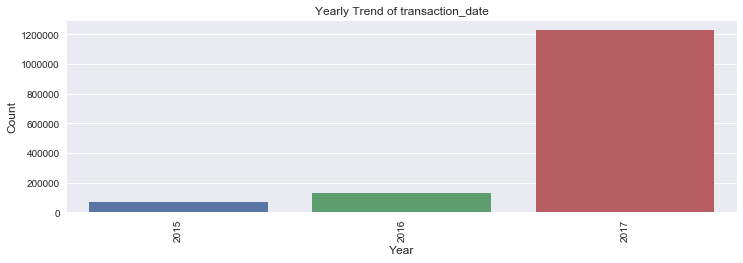

Yearly Count [(2017, 1231609), (2016, 128034), (2015, 71366)]


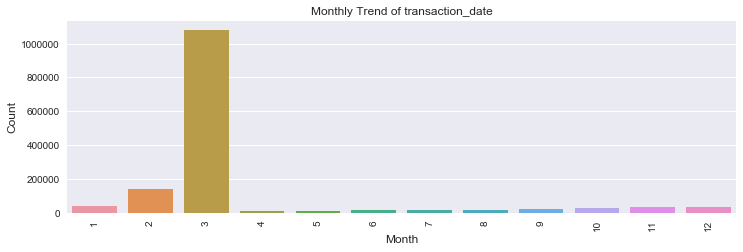

Monthly Count [(3, 1081455), (2, 137462), (1, 36647), (12, 34407), (11, 30114), (10, 26965), (9, 18278), (8, 15229), (7, 14763), (6, 12319), (5, 11824), (4, 11546)]


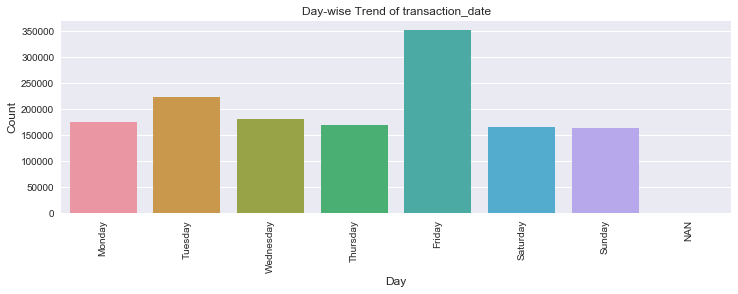

Day-wise Count [('Friday', 352742), ('Tuesday', 224090), ('Wednesday', 180444), ('Monday', 174814), ('Thursday', 170055), ('Saturday', 164744), ('Sunday', 164120)]


In [18]:
#transaction_date yearly trend
trans_data['transaction_date_year'] = pd.DatetimeIndex(trans_data['transaction_date']).year
trans_data['transaction_date_year'] = trans_data.transaction_date_year.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )

year_count = trans_data['transaction_date_year'].value_counts()
#print(year_count)

plt.figure(figsize=(12,12))
plt.subplot(311)
year_order = trans_data['transaction_date_year'].unique()
year_order=sorted(year_order, key=lambda x: str(x))
year_order = sorted(year_order, key=lambda x: float(x))
sns.barplot(year_count.index, year_count.values,order=year_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Yearly Trend of transaction_date", fontsize=12)
plt.show()
year_count_2 = Counter(trans_data['transaction_date_year']).most_common()
print("Yearly Count " +str(year_count_2))


#transaction_date monthly trend
trans_data['transaction_date_month'] = pd.DatetimeIndex(trans_data['transaction_date']).month
trans_data['transaction_date_month'] = trans_data.transaction_date_month.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )

month_count = trans_data['transaction_date_month'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(312)
month_order = trans_data['transaction_date_month'].unique()
month_order = sorted(month_order, key=lambda x: str(x))
month_order = sorted(month_order, key=lambda x: float(x))
sns.barplot(month_count.index, month_count.values,order=month_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Monthly Trend of transaction_date", fontsize=12)
plt.show()
month_count_2 = Counter(trans_data['transaction_date_month']).most_common()
print("Monthly Count " +str(month_count_2))


#transaction_date day wise trend
trans_data['transaction_date_weekday'] = pd.DatetimeIndex(trans_data['transaction_date']).weekday_name
trans_data['transaction_date_weekday'] = trans_data.transaction_date_weekday.apply(lambda x: str(x) if pd.notnull(x) else "NAN" )

day_count = trans_data['transaction_date_weekday'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(313)
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','NAN']
sns.barplot(day_count.index, day_count.values,order=day_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Day-wise Trend of transaction_date", fontsize=12)
plt.show()
day_count_2 = Counter(trans_data['transaction_date_weekday']).most_common()
print("Day-wise Count " +str(day_count_2))

BE CAUTIOUS WITH THESE GRAPHS BECAUSE OF THE DATA WE ARE GIVEN
- **Transaction date** has increased yearly. Thus, there are more transactions done now than a few years ago. This is probably because there are more users subscribed.
- **Transaction date** monthly trends are high in february and march (a huge increase) followed by january and december. In the rest of the months, the transactions are more or less constant and small (in comparison).
- **Transaction date** day-wise trends are higher in friday, maybe people finish working and doing their matters and remember to pay/renew their subscription facing the weekend (to listed music).

#### B. Analysis of _membership expire date_ trends

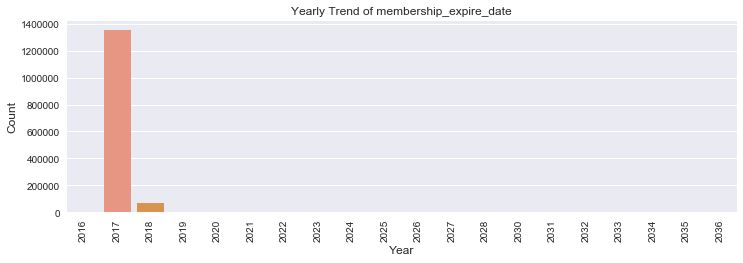

Yearly Count [(2017, 1354731), (2018, 66549), (2019, 6735), (2020, 2074), (2021, 604), (2022, 143), (2023, 41), (2024, 32), (2027, 32), (2026, 20), (2025, 20), (2016, 11), (2028, 10), (2036, 1), (2034, 1), (2030, 1), (2032, 1), (2033, 1), (2035, 1), (2031, 1)]


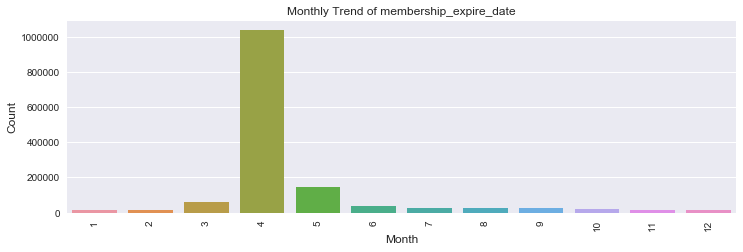

Monthly Count [(4, 1037972), (5, 142927), (3, 57106), (6, 39078), (7, 27782), (8, 26938), (9, 25030), (10, 18034), (11, 14913), (1, 14268), (2, 13532), (12, 13429)]


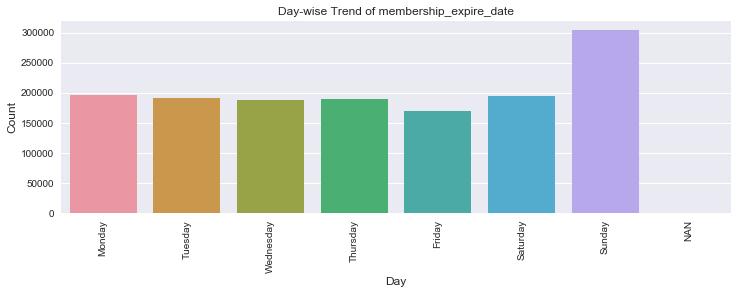

Day-wise Count [('Sunday', 304252), ('Monday', 195376), ('Saturday', 194095), ('Tuesday', 190830), ('Thursday', 188693), ('Wednesday', 188278), ('Friday', 169485)]


In [19]:
#membership_expire_date yearly trend
trans_data['membership_expire_date_year'] = pd.DatetimeIndex(trans_data['membership_expire_date']).year
trans_data['membership_expire_date_year'] = trans_data.membership_expire_date_year.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )

year_count = trans_data['membership_expire_date_year'].value_counts()
#print(year_count)

plt.figure(figsize=(12,12))
plt.subplot(311)
year_order = trans_data['membership_expire_date_year'].unique()
year_order=sorted(year_order, key=lambda x: str(x))
year_order = sorted(year_order, key=lambda x: float(x))
sns.barplot(year_count.index, year_count.values,order=year_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Yearly Trend of membership_expire_date", fontsize=12)
plt.show()
year_count_2 = Counter(trans_data['membership_expire_date_year']).most_common()
print("Yearly Count " +str(year_count_2))


#membership_expire_date monthly trend
trans_data['membership_expire_date_month'] = pd.DatetimeIndex(trans_data['membership_expire_date']).month
trans_data['membership_expire_date_month'] = trans_data.membership_expire_date_month.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )

month_count = trans_data['membership_expire_date_month'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(312)
month_order = trans_data['membership_expire_date_month'].unique()
month_order = sorted(month_order, key=lambda x: str(x))
month_order = sorted(month_order, key=lambda x: float(x))
sns.barplot(month_count.index, month_count.values,order=month_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Monthly Trend of membership_expire_date", fontsize=12)
plt.show()
month_count_2 = Counter(trans_data['membership_expire_date_month']).most_common()
print("Monthly Count " +str(month_count_2))


#membership_expire_date day wise trend
trans_data['membership_expire_date_weekday'] = pd.DatetimeIndex(trans_data['membership_expire_date']).weekday_name
trans_data['membership_expire_date_weekday'] = trans_data.membership_expire_date_weekday.apply(lambda x: str(x) if pd.notnull(x) else "NAN" )

day_count = trans_data['membership_expire_date_weekday'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(313)
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','NAN']
sns.barplot(day_count.index, day_count.values,order=day_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Day-wise Trend of membership_expire_date", fontsize=12)
plt.show()
day_count_2 = Counter(trans_data['membership_expire_date_weekday']).most_common()
print("Day-wise Count " +str(day_count_2))

- **Membership expire date** has the higher distribution in 2017, followed by 2018. Then, there are many years far apart from 2017 and they may be outliers as I does not seem logical such a long subscription. These large values for the years have only 1 or 10 values (not very remarkable).
FOCUS ONLY UNTIL 2024.
- **Membership expire date** monthly trends are high in march, april and may. It seems logical as the **transaction date** was higher in february and march, so in a short period the membership is expiring (unless renewed).
- **Membership expire date** day-wise trends are higher in sunday.

In [20]:
#Now there are 6 more features (2 for year, 2 for month and 2 for weekday)
trans_data.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,diff_plan_actual,transaction_date_year,transaction_date_month,transaction_date_weekday,membership_expire_date_year,membership_expire_date_month,membership_expire_date_weekday
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,2017-01-31,2017-05-04,0,0,2017,1,Tuesday,2017,5,Thursday
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-08-09,2019-04-12,0,0,2015,8,Sunday,2019,4,Friday
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,2017-03-03,2017-04-22,0,0,2017,3,Friday,2017,4,Saturday
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,2017-03-29,2017-03-31,1,0,2017,3,Wednesday,2017,3,Friday
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,2017-03-23,2017-04-23,0,0,2017,3,Thursday,2017,4,Sunday


### 1.2.6. Feature: Is Cancel
Show if a user cancel a transaction. If so, this is more likely to churn. Most of then, do NOT cancel.

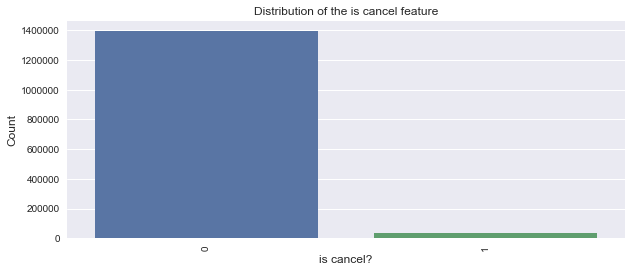

is_cancel Count [(0, 1395876), (1, 35133)]


In [21]:
sns.set(rc={'figure.figsize':(10,4)}) #Horizontal, vertical
sns.countplot(x='is_cancel',data=trans_data)
plt.ylabel('Count', fontsize=12)
plt.xlabel('is cancel?', fontsize=12)
plt.xticks(rotation = 'vertical')
plt.title("Distribution of the is cancel feature", fontsize=12)
plt.show()

is_cancel_count = Counter(trans_data['is_cancel']).most_common()
print("is_cancel Count " +str(is_cancel_count))

Only 4% of the users have canceled the subscription during the plan period.

### 1.2.7. Check missing values in the features

In [22]:
trans_data.apply(lambda x: sum(x.isnull()),axis=0) 

msno                              0
payment_method_id                 0
payment_plan_days                 0
plan_list_price                   0
actual_amount_paid                0
is_auto_renew                     0
transaction_date                  0
membership_expire_date            0
is_cancel                         0
diff_plan_actual                  0
transaction_date_year             0
transaction_date_month            0
transaction_date_weekday          0
membership_expire_date_year       0
membership_expire_date_month      0
membership_expire_date_weekday    0
dtype: int64

As there are not missing values, go on. This is OK.

### Talking about users (msno = ID)
The same user can have different "payment plan duration" with different "subscription time".
For example, the same user can have the 149 plan (but paid 119 maybe due to some discount). Later on, pass to the 129 plan. Finally, pass to another plan again.

## 1.3. Individual features vs. output (is_churn)
### 1.3.1 Load data

In [23]:
data1 = pd.read_csv("data/train_v2.csv")

### 1.3.2. Merge

In [24]:
result_dataset = pd.merge(trans_data, data1, on='msno')
result_dataset.head(10)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,diff_plan_actual,transaction_date_year,transaction_date_month,transaction_date_weekday,membership_expire_date_year,membership_expire_date_month,membership_expire_date_weekday,is_churn
0,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-08-09,2019-04-12,0,0,2015,8,Sunday,2019,4,Friday,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-01-07,2017-06-12,0,0,2015,1,Wednesday,2017,6,Monday,0
2,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-10-09,2019-09-11,0,0,2015,10,Friday,2019,9,Wednesday,0
3,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-02-07,2017-09-10,0,0,2015,2,Saturday,2017,9,Sunday,0
4,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,119,1,2015-04-09,2018-05-07,0,30,2015,4,Thursday,2018,5,Monday,0
5,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-11-09,2019-12-12,0,0,2015,11,Monday,2019,12,Thursday,0
6,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-01-09,2017-07-13,0,0,2015,1,Friday,2017,7,Thursday,0
7,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,0,0,149,1,2015-05-07,2018-06-07,0,-149,2015,5,Thursday,2018,6,Thursday,0
8,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,0,0,149,1,2015-05-09,2018-08-08,0,-149,2015,5,Saturday,2018,8,Wednesday,0
9,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-02-09,2017-10-08,0,0,2015,2,Monday,2017,10,Sunday,0


#### Obtain 2 datasets: churned and NOT churned

In [25]:
members_churn_is0 = result_dataset[result_dataset.is_churn == 0] #DataFrame
members_churn_is1 = result_dataset[result_dataset.is_churn == 1] #DataFrame

### 1.3.3. Payment Method compare to is_Churn

I will take values above 30 (significant amount of payment method above 30)

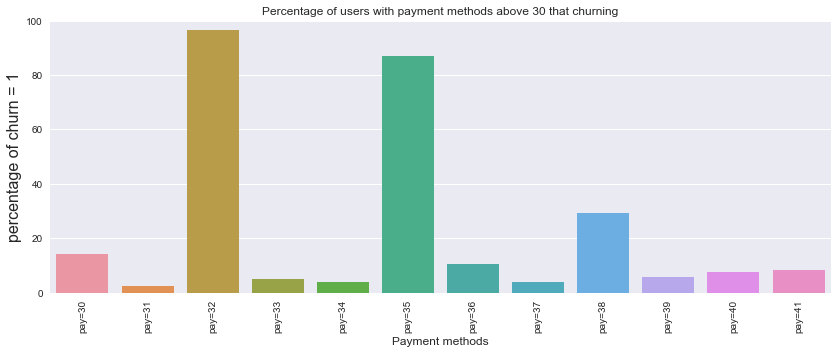

In [26]:
#Percentage of user with payment_method_id = 30 where churn is 1
perc_30 = 100*members_churn_is1[members_churn_is1.payment_method_id == 30].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 30].payment_method_id.count()
perc_31 = 100*members_churn_is1[members_churn_is1.payment_method_id == 31].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 31].payment_method_id.count()
perc_32 = 100*members_churn_is1[members_churn_is1.payment_method_id == 32].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 32].payment_method_id.count()
perc_33 = 100*members_churn_is1[members_churn_is1.payment_method_id == 33].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 33].payment_method_id.count()
perc_34 = 100*members_churn_is1[members_churn_is1.payment_method_id == 34].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 34].payment_method_id.count()
perc_35 = 100*members_churn_is1[members_churn_is1.payment_method_id == 35].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 35].payment_method_id.count()
perc_36 = 100*members_churn_is1[members_churn_is1.payment_method_id == 36].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 36].payment_method_id.count()
perc_37 = 100*members_churn_is1[members_churn_is1.payment_method_id == 37].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 37].payment_method_id.count()
perc_38 = 100*members_churn_is1[members_churn_is1.payment_method_id == 38].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 38].payment_method_id.count()
perc_39 = 100*members_churn_is1[members_churn_is1.payment_method_id == 39].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 39].payment_method_id.count()
perc_40 = 100*members_churn_is1[members_churn_is1.payment_method_id == 40].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 40].payment_method_id.count()

perc_41 = 100*members_churn_is1[members_churn_is1.payment_method_id == 41].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 41].payment_method_id.count()

p=[perc_30, perc_31, perc_32, perc_33, perc_34, perc_35, perc_36, perc_37, perc_38, perc_39, perc_40, perc_41]
g=["pay=30","pay=31","pay=32","pay=33","pay=34","pay=35","pay=36","pay=37","pay=38","pay=39","pay=40","pay=41"]

plt.figure(figsize = (14,5))
plt.ylim(0, 100)
plt.ylabel('percentage of churn = 1', fontsize = 16)
plt.xlabel('Payment methods', fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.title("Percentage of users with payment methods above 30 that churning", fontsize=12)
sns.barplot(g,y = p)

### 1.3.4. Payment plan duration (in days) compare to is_Churn
I will take values below 195 (significant amount of payment method above 30)

/Users/pablodepaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/Users/pablodepaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/Users/pablodepaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


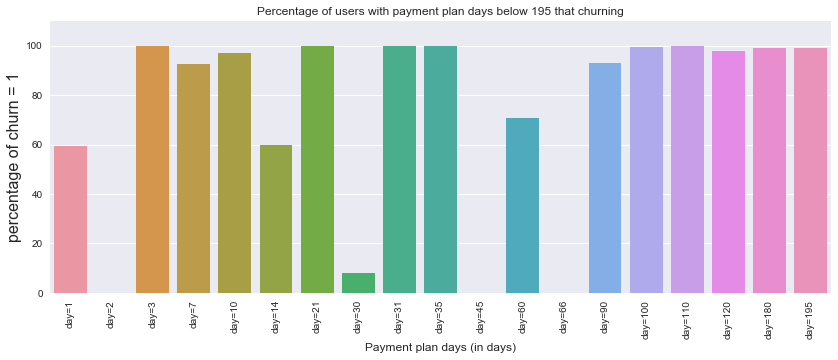

In [114]:
#print("% of user with payment_method_id = 30 churning (churn = 1)")
percent_0 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 0].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 0].payment_plan_days.count()

percent_1 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 1].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 1].payment_plan_days.count()
percent_2 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 2].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 2].payment_plan_days.count()
percent_3 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 3].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 3].payment_plan_days.count()
percent_7 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 7].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 7].payment_plan_days.count()

percent_10 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 10].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 10].payment_plan_days.count()
percent_14 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 14].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 14].payment_plan_days.count()

percent_21 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 21].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 21].payment_plan_days.count()

percent_30 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 30].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 30].payment_plan_days.count()
percent_31 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 31].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 31].payment_plan_days.count()
percent_35 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 35].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 35].payment_plan_days.count()

percent_45 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 45].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 45].payment_plan_days.count()

percent_60 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 60].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 60].payment_plan_days.count()
percent_66 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 66].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 66].payment_plan_days.count()

#percent_70 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 70].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 70].payment_plan_days.count()
#percent_80 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 80].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 80].payment_plan_days.count()

percent_90 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 90].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 90].payment_plan_days.count()
#percent_99 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 99].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 99].payment_plan_days.count()

percent_100 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 100].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 100].payment_plan_days.count()
percent_110 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 110].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 110].payment_plan_days.count()
percent_120 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 120].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 120].payment_plan_days.count()
percent_180 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 180].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 180].payment_plan_days.count()
percent_195 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 195].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 195].payment_plan_days.count()


p=[percent_1, percent_2, percent_3, percent_7, percent_10, percent_14, percent_21, percent_30, percent_31, percent_35, percent_45, percent_60, percent_66, percent_90, percent_100, percent_110, percent_120, percent_180, percent_195]
g=["day=1","day=2","day=3","day=7","day=10","day=14","day=21","day=30","day=31","day=35","day=45","day=60","day=66","day=90","day=100","day=110","day=120","day=180","day=195"]

plt.figure(figsize=(14,5))
plt.ylim(0, 110)
plt.ylabel('percentage of churn = 1', fontsize = 16)
plt.xlabel('Payment plan days (in days)', fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.title("Percentage of users with payment plan days below 195 that churning", fontsize=12)
sns.barplot(g,y = p)

### 1.3.5. Plan Price and Amount Paid compare to is_Churn
I will just take values 0, 99, 100, 129, 149 (the largest), 150, 180.

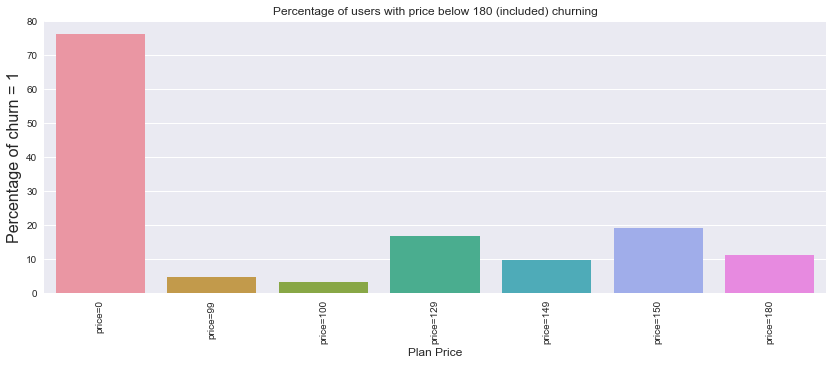

In [124]:
p_0 = 100*members_churn_is1[members_churn_is1.plan_list_price == 0].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 0].plan_list_price.count()
p_99 = 100*members_churn_is1[members_churn_is1.plan_list_price == 99].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 99].plan_list_price.count()
p_100 = 100*members_churn_is1[members_churn_is1.plan_list_price == 100].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 100].plan_list_price.count()
p_129 = 100*members_churn_is1[members_churn_is1.plan_list_price == 129].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 129].plan_list_price.count()
p_149 = 100*members_churn_is1[members_churn_is1.plan_list_price == 149].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 149].plan_list_price.count()
p_150 = 100*members_churn_is1[members_churn_is1.plan_list_price == 150].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 150].plan_list_price.count()
p_180 = 100*members_churn_is1[members_churn_is1.plan_list_price == 180].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 180].plan_list_price.count()

p=[p_0, p_99,p_100,p_129,p_149,p_150,p_180]
g=["price=0","price=99","price=100","price=129","price=149","price=150","price=180"]

plt.figure(figsize=(14,5))
plt.ylim(0, 80)
plt.ylabel('Percentage of churn = 1', fontsize=16)
plt.xlabel('Plan Price', fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.title("Percentage of users with price below 180 (included) churning", fontsize=12)
sns.barplot(g,y = p)

### 1.3.6. is_auto_renew compare to is_Churn

% of user with auto_renew = 1 churning (churn=1)
7.654494517423353
% of user with auto_renew = 0 churning (churn=1)
36.06754617414248


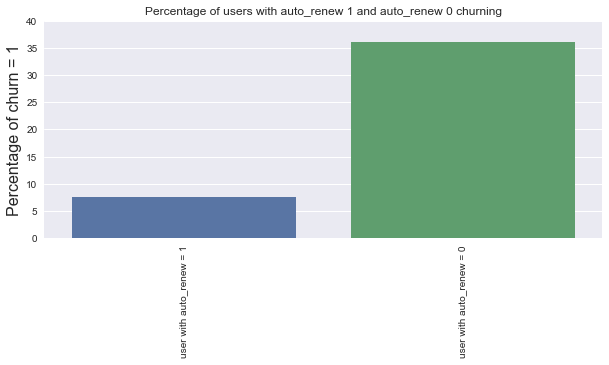

In [120]:
#Percentage of user with auto_renew = 1 where churn is 1
print("% of user with auto_renew = 1 churning (churn=1)")
perc_1 = 100*members_churn_is1[members_churn_is1.is_auto_renew == 1].is_auto_renew.count()/result_dataset[result_dataset.is_auto_renew == 1].is_auto_renew.count()
print(perc_1)

#Percentage of user with auto_renew = 0 where churn is 1
print("% of user with auto_renew = 0 churning (churn=1)")
perc_0 = 100*members_churn_is1[members_churn_is1.is_auto_renew == 0].is_auto_renew.count()/result_dataset[result_dataset.is_auto_renew == 0].is_auto_renew.count()
print(perc_0)

p=[perc_1,perc_0]
g=["user with auto_renew = 1","user with auto_renew = 0"]

plt.ylim(0, 40)
plt.ylabel('Percentage of churn = 1', fontsize=16)
plt.xticks(rotation = 'vertical')
plt.title("Percentage of users with auto_renew 1 and auto_renew 0 churning", fontsize=12)
sns.barplot(g,y = p)

### 1.3.7. is_cancel compare to is_Churn

% of user with is_cancel = 1 churning (churn=1)
59.57485630873096
% of user with is_cancel = 0 churning (churn=1)
8.550492970496373


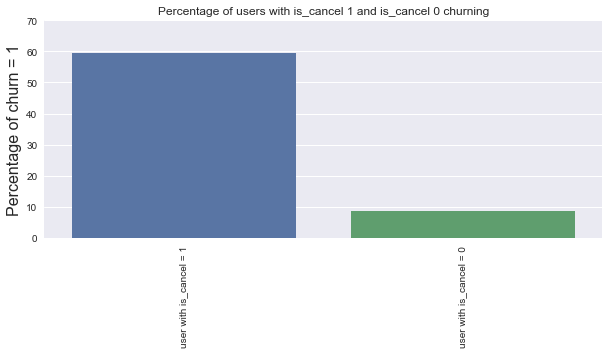

In [119]:
#Percentage of user with is_cancel = 1 where churn is 1
print("% of user with is_cancel = 1 churning (churn=1)")
perc_1 = 100*members_churn_is1[members_churn_is1.is_cancel == 1].is_cancel.count()/result_dataset[result_dataset.is_cancel == 1].is_cancel.count()
print(perc_1)

#Percentage of user with is_cancel = 0 where churn is 1
print("% of user with is_cancel = 0 churning (churn=1)")
perc_0 = 100*members_churn_is1[members_churn_is1.is_cancel == 0].is_cancel.count()/result_dataset[result_dataset.is_cancel == 0].is_cancel.count()
print(perc_0)

p=[perc_1,perc_0]
g=["user with is_cancel = 1","user with is_cancel = 0"]

plt.ylim(0, 70)
plt.ylabel('Percentage of churn = 1', fontsize=16)
plt.xticks(rotation = 'vertical')
plt.title("Percentage of users with is_cancel 1 and is_cancel 0 churning", fontsize=12)
sns.barplot(g,y = p)

## 1.4. Correlation analysis
Comparison between features.

## 1.5. Conclusion

**transactions** dataset is a really important dataset. Most of the features here are really important for the later predictions (mainly dates, payment methods and plan days).
Please take a look, to get a better insight, the data of the graphs that do not have outliers/extreme values.